In [1]:
import numpy as np
from scipy.integrate import odeint #For ODE integration
import matplotlib.pyplot as plt #For plotting
#import seaborn as sns 
import pymc as pm
from pymc.ode import DifferentialEquation
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


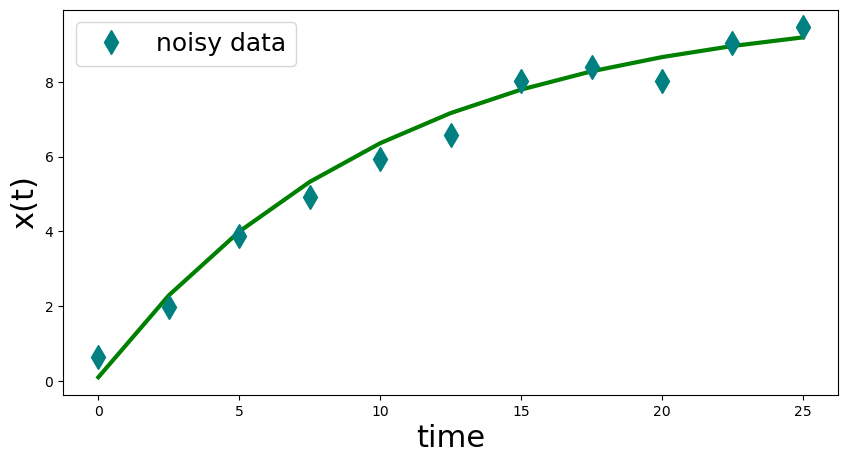

In [2]:
#Define the ODE system in the following function
def BirthDeath(x, t, p):
    lam = p[0]
    mu = p[1]
    dx = lam - mu * x[0]
    return dx

#### Create some synthetic data

np.random.seed(24)

t0=0.0  #Initial time
tfinal = 25.0  #Final time  
N=10  #Number of data points          
t_vec = np.linspace(t0, tfinal, N+1) # Creates a uniform grid on the time axis
#t_vec = np.arange(t0,tfinal,2)

#Set initial conditions and parameters
x_0 = np.array([0.1]) #Initial value of the population
true_lam=1
true_mu=0.1

#### Integrate the ODE
sol = odeint(BirthDeath, x_0, t_vec, tuple([[true_lam,true_mu]]))

#### Plot results
plt.figure(figsize=(10,5))
plt.plot(t_vec, sol[:, 0], lw=3, color='g')
plt.xlabel('time',fontsize=22)
plt.ylabel('x(t)',fontsize=22)
plt.show
#add noise 
sigma_e = np.array([0.4]); #standard deviation of the added Gaussian noise
noisyData =np.random.normal(sol, sigma_e)
#yobs = np.ndarray.flatten(noisyData)
plt.plot(t_vec, noisyData, marker='d', color='teal', linestyle="None",markersize=12, label='noisy data')
plt.legend(fontsize=18)

In [3]:
ode_model = DifferentialEquation(func=BirthDeath, times=t_vec, n_states=1, n_theta=2, t0=t0)

with pm.Model() as model:
    # Specify prior distributions for our model parameters
    lam = pm.Normal("lambda", 1.1, 1)
    mu = pm.Normal("mu", 0.2, 1)
    sigma = pm.HalfNormal('sigma', 1)

    ode_solution = ode_model(y0=x_0, theta=[lam, mu])
    # The ode_solution has a shape of (n_times, n_states)
    
    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=noisyData)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(500)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    #data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)


Sampling: [Y, lambda, mu, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, mu, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 978 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Y]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.885,0.065,0.762,1.002,0.003,0.002,556.252,651.659,1.009
mu,0.084,0.011,0.063,0.103,0.000,0.000,566.620,702.518,1.008
sigma,0.397,0.107,0.221,0.596,0.004,0.003,605.313,816.209,1.004


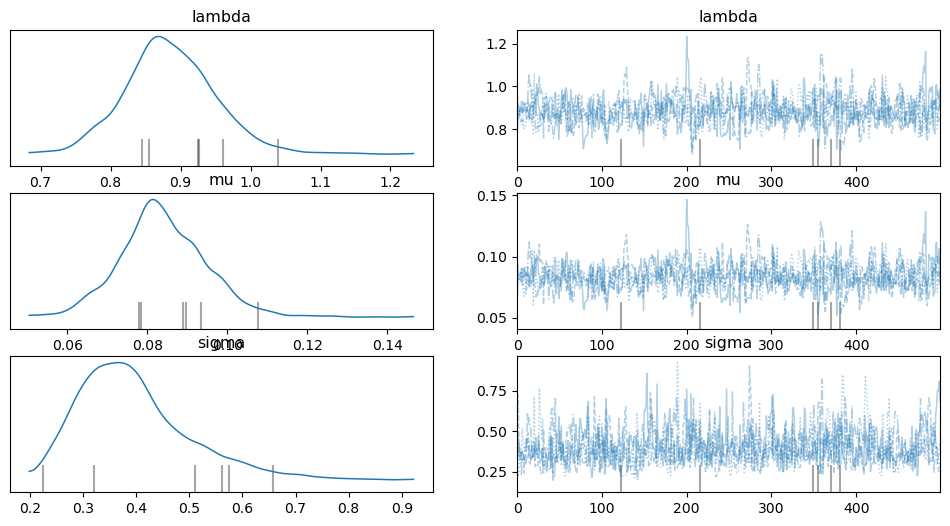

In [55]:
#### Analyze the fit
az.plot_trace(trace,combined=True);
az.summary(trace, var_names=["lambda","mu","sigma"], round_to=3)

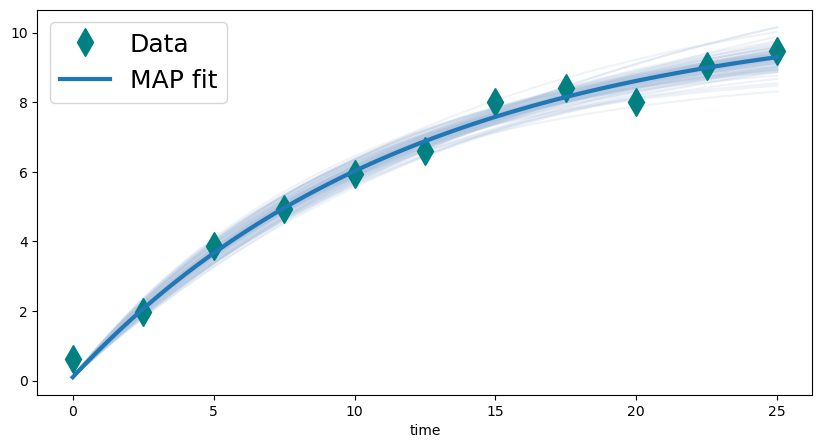

In [50]:
##### plot the fit results
lam_samples = trace.posterior['lambda'][0]
mu_samples = trace.posterior['mu'][0]

# Choose some points from the posterior distribution and plot the corresponding result
plt.figure(figsize=(10,5))
sz = 50
idx=np.random.randint(0,len(lam_samples),sz)
t_plot=np.linspace(t0, tfinal, 100)
for i in idx:
    sol = odeint(BirthDeath, x_0, t_plot, tuple([[lam_samples[i],mu_samples[i]]]))
    plt.plot(t_plot, sol[:, 0], color='lightsteelblue', alpha=0.2)

#plot data
plt.plot(t_vec, noisyData, marker='d', color='teal', linestyle="None",markersize=14, label='Data')

#plot MAP fit
mp = pm.find_MAP(model=model)
lambda_MAP = mp["lambda"]
mu_MAP = mp["mu"]
MAP_sol = odeint(BirthDeath, x_0, t_plot, tuple([[lambda_MAP,mu_MAP]]))
plt.plot(t_plot, MAP_sol[:, 0],lw=3, label='MAP fit')
plt.xlabel('time')
plt.legend(fontsize=18)  

Text(0.5, 1.0, 'Joint Posterior for $\\lambda$ and $\\mu$')

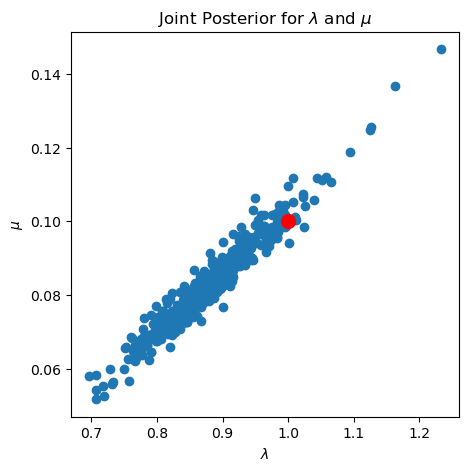

In [56]:
# Plot the pariwise posterior
plt.figure(figsize=(5,5))
plt.scatter(lam_samples,mu_samples,)
plt.plot(true_lam,true_mu,marker='o', color='r', markersize=10)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\mu$')
plt.title(r'Joint Posterior for $\lambda$ and $\mu$')